# Predicting physical properties with 2CLJQ surrogate models

## Why are we interested in parameters?

*Force Field Parameterization* is an important issue in atomistic simulations.  In order to cheaply simulate the interactions of molecules, we use simple models called force fields.  Force fields describe the interactions of a set of atoms (which can either be bonded together or non-bonded) along with their positions in space.

$$ E_{potential} (\vec{x}) = E_{bond} (\vec{x}) + E_{nonbond} (\vec{x})  $$

Where $E_{bond}$ and $E_{nonbond}$ are simple analytical forms that have a couple of *parameters*, which are constants that differentiate the different chemical identities of the interactions (e.g., how we tell a C-C bond from a C=O bond).

For example, here is the potential for the Lennard-Jones dispersion-repulsion interactions:

$$ E_{LJ} = 4 \epsilon \left( \left(\frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r} \right)^{6} \right) $$.
 
The parameters in this case are $\epsilon$ and $\sigma$; they correspond to the identities of the molecules involved in this interaction.

Parameters are crucial for success in molecular simulation because they determine how accurate the simple potentials reproduce the true potential energy surface.  There is significant interest in getting good values, that correspond to physical reality.

## How do we choose our parameters?

On a broad scale, parameters are chosen by comparing to quantum mechanics calculations (DFT) or experimental properties.

### Bonded interactions

Bonded interactions are the **easiest** (but still not easy!!!) parameters to get right, because QM calculations can produce values for bond lengths, angles, and torsions.  You can run QM calculations for pretty much any molecule you want, and there is a 1:1 mapping there (i.e. QM bond length --> bond length parameter) so these are generally easier to do.

### Non-bonded interactions

Non-bonded interactions (typically split into electrostatic and dispersion-repulsion interactions) are harder to parameterize.

**Electrostatics**: Electrostatic interactions are parameterized by point charges, and are generally assumed to follow Coulomb's law.  You can get electrostatic surface potentials (ESPs) from QM calculations, but then you have to figure out how to map a distribution of electron density to a single point, so this can be difficult.

**Dispersion-Repulsion Interactions**: These are exceptionally difficult because QM calculations generally don't reproduce them, and so you can't just run a DFT calculation of your molecule and get out the parameters.  Additionally, you still have the mapping problem of getting an electronic density surface mapped to a single point.

So instead, we parameterize these interactions against macroscopic physical properties (density, enthalpies, etc...) with the hope that if we've already done a good job picking the other parameters (not always a good assumption), that fitting the dispersion repulsion (often Lennard Jones) interactions against physical properties will yield good results.

For this reason, we're interested in physical properties.  Generally, the procedure for parameterization looks something like this:  run a simulation with a given set of parameters, compare that set of parameters against physical properties, then tweak the parameters and repeat the process until you get some level of convergence.

## Why surrogate models?

### What is a surrogate model?

A surrogate model is any sort of function that *approximates* the response of a more complex function, in an effort to reduce cost/complexity of evaluating the more complex function.

Since we are interested in simulating physical properties to parameterize LJ interactions, we will need to run lots of iterations of the "simulate property --> tweak parameters" loop.  The problem is, simulating a physical property takes ~ 1 hr, so if we are going to do this many times, it will take a really long time.

Here is where a surrogate model comes in:  if we can use a surrogate *based on molecular simulations* to simulate the physical properties at a much lower computational cost, then we can run our parameterization loop many more times, allowing us to hopefully get better values.

### The 2CLJQ model

Developing surrogate models is a different challenge from *using* them as part of a parameterization routine.  To test the latter without the former, we take surrogates already developed for the 2-center Lennard Jones + Quadrupole (2CLJQ) model, which is a simple model for diatomic and diatomic-like molecules.  By running many simulations of this model for different compounds and values and fitting the results to an analytical function, the authors of these models (Stoll and Werth) created simple surrogates that can predict saturated liquid density, saturation pressure, and surface tension ($\rho_{liq}, P_{sat}, \gamma$).

For example:



In [2]:
from bayesiantesting import surrogates
from bayesiantesting.datasets.nist import NISTDataType
import numpy
from bayesiantesting import unit

ethane_mw = 30 * unit.gram / unit.mole
#The 2CLJQ model specifies the compound by a molecular weight ( as well as parameters defined later)

testsurrogate = surrogates.StollWerthSurrogate(molecular_weight=ethane_mw)
#Create a Stoll-Werth surrogate model.  This object contains surrogate models that can predict
#saturated liquid densities, saturation pressures, and surface tension as a function of parameters
# temperature, and compound (for a 2CLJQ model)

density = NISTDataType.LiquidDensity
#Specify the type of measurement that we are looking for; in this case, liquid density.


temperatures = numpy.linspace(100,200,num=11)
#Specify the temperatures that we want to evaluate the surrogate model at.  Note that these will only work
#for temperatures where the compound is liquid


eps = 140
#LJ Epsilon in K
sigma = 0.35
# LJ sigma in angstrom
l=0.25
#Bond length in angstrom
Q=0.15
#Quadrupole moment in Debye - Angstrom
parameters = numpy.asarray([eps,sigma,l,Q])
#Define a set of parameters to parameterize the 2CLJQ model
#


density_output = testsurrogate.evaluate(density,parameters,temperatures)
#Evaluate the surrogate model densities at the desired temperatures.

print(density_output)

[620.25480539 610.0627823  599.62874391 588.93590943 577.9650746
 566.69408343 555.09714194 543.14391232 530.79829534 518.01675923
 504.74599109]


In this example, we defined a model for ethane (C2H6), based on it's molecular weight and the four parameters that define the 2CLJQ model:  a Lennard Jones $\epsilon$ and $\sigma$, a bond length L, and a quadrupole moment Q that describes the strength of the quadrupole interaction.  Then we initialized a surrogate model object based of the Stoll Werth surrogate model, specified the type of property we wanted to simulate, chose some parameters to parameterize the model, and gave it a list of temperatures to predict properties at.  The output is a list of predicted densities from 100 - 200 K, in 10 K increments.

## Comparing surrogate model results to experimental data

Since comparing our simulation results based on our parameters is an essential step of how we parameterize, lets give an example of doing that. 

In [3]:
from bayesiantesting.datasets.nist import NISTDataSet, NISTDataType
from bayesiantesting import unit

ethane_data = NISTDataSet('C2H6')
#This loads in a dataset of physical properties at various temperatures from NIST, for ethane (C2H6)

temp_range = [0.6,0.8]
num_points = 10
#Temperature range (in fraction of critical temperature).  Absolute temperatures are a bit tricky
#because the model won't be valid over the critical temperature.

minimum_temperature = (
    0.6
    * ethane_data.critical_temperature.value.to(unit.kelvin).magnitude
)
maximum_temperature = (
    0.8
    * ethane_data.critical_temperature.value.to(unit.kelvin).magnitude
)

ethane_data.filter(
    minimum_temperature * unit.kelvin,
    maximum_temperature * unit.kelvin,
    num_points,
)
#These commands will select 10 data points with uncertainties (and corresponding temperatures) for each property available
# In the chosen temperature range.
density = NISTDataType.LiquidDensity
ethane_densities = ethane_data.get_data(density)
print(ethane_densities)

       T (K)  rhol (kg/m3)  urho (kg/m3)
212  184.712       542.200         3.300
215  185.169       543.050         0.420
221  190.012       537.086         0.538
226  195.000       530.542         0.174
231  199.023       524.910         0.440
236  201.411       521.500         3.100
241  207.439       513.490         0.450
249  212.632       506.270         0.450
256  220.009       496.119         0.499
263  228.369       483.270         0.470
271  232.116       478.230         0.470


Now that we've retrieved some data to compare against, let's see how the surrogate model compares:

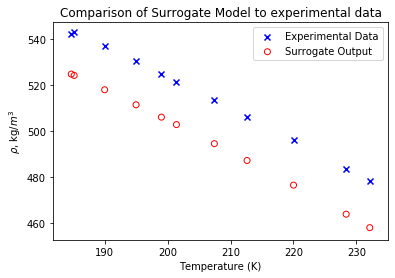

In [4]:
temperatures = numpy.asarray(ethane_densities['T (K)'])


ethane_surrogate_densities = testsurrogate.evaluate(density,parameters,temperatures)
#Evaluate the surrogate model (with parameters from before) for new temperatures

import matplotlib.pyplot as plt

plt.scatter(temperatures,ethane_densities['rhol (kg/m3)'], marker='x', color='b',label='Experimental Data')
plt.scatter(temperatures,ethane_surrogate_densities, marker='o', facecolors='none',edgecolors='r',label='Surrogate Output')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\rho$, kg/$m^3$')
plt.title('Comparison of Surrogate Model to experimental data')
plt.legend()
plt.show()


Here, we can see that the surrogate model does a **qualitatively** good job of reproducing the data trend, but not a **quantitatively** good job (the values are off significantly).  Let's walk through a quick example of how we would adjust these parameters to do a better job.

## Using Bayesian Inference to explore parameter space

Since the parameters we are using are continuous (real-valued), we can think of parameter optimization as searching a 4-dimensional box for the best values of parameters. In order to make this happen, we need two things:

1) A metric for deciding how good a set of parameters is.

2) A method for exploring the space.

### Parameter fitness: Bayesian inference.

To decide parameter fitness, we use a Bayesian formulation.  Bayesian inference is based on Bayes' rule:

$$ P(\theta | D) \propto P(D | \theta) P(\theta) $$

Where $\theta$ are the parameters, and $D$ is the data.  Each of these probabilities has a name:

$P(\theta)$: **Prior**.  This encompasses our prior knowledge about the what the parameters should be. For example, it could be things like mathematical constraints on the parameters (e.g. bond length must be >= 0), or physical constraints (we know the bond length should be around 0.4 Angstroms from DFT simulations).  Priors are important because they contain all the previous information we have about parameters, and keep things grounded (e.g. our optimization doesn't take us off into nonsensical parameter space).

$P(D | \theta)$: **Likelihood**.  This probability tells us how likely the parameters are to reproduce the experimental data under the specific context of our current experiments.  So, this is something like: how well do our parameters reproduce the specific density data we are looking at?  In our context we generally compute the likelihood by treating the experiment data as ground truth and asking the likelihood of drawing the surrogate value from a normal distribution centered on the experimental data.  This is the part where surrogate models come in.

$P(\theta | D)$: **Posterior**.  This is the (un-normalized) combination of the likelihood and the prior.  It is the *updated parameter distribution*: the probability of each set of parameters after the information from both the likelihood and the prior is included.

### Exploring space with Monte Carlo Methods

Since we have a metric for parameter 'fitness' defined, we can use that metric to find the 'most fit' sets of parameters.  However, the tricky part here is that because the likelihood is, in general, not an analytical function, we can't just automatically compute posterior probabilities.  

Instead, we can use Markov Chain Monte Carlo (MCMC) methods to sample values from the posterior probability distribution (this may be a little confusing conceptually and we can discuss later if need be).  If we sample enough values, the frequency at which they are sampled will approximate the true posterior distribution, and can get an idea of how that looks like.

I'll gloss over the details of how MCMC sampling actually works, but the idea is that you're able to draw samples from a probability distribution by randomly proposing new moves and the accepting or rejecting those moves based on some criteria (most commonly the Metropolis-Hastings criteria).

So, the algorithm will look something like this:

1) Starting from one set of parameters, use surrogate model to evaluate likelihood of those parameters

2) Combine likelihood with prior to get posterior probability of those parameters (1 draw from the posterior distribution)

3) Propose a new set of parameters, at random or by modifying the current parameters.

4) Evaluate posterior of the new parameter set using surrogate models and prior

5) Compare new posterior to old posterior, and accept or reject the new parameters based on M-H criteria.

6) If move is accepted, the draw is the new set of parameters; if not, it is the old set.

7) Repeat steps 3-6 until you have good sampling of the posterior distribution over the parameter space.

We can get into the details later, but here's an example of this in action:

This simulation should take about a minute.



  2%|▏         | 331/20001 [00:00<00:05, 3309.92it/s]

Loading simulation params from basic_run.yaml...
Warm-up simulation:



100%|█████████▉| 20000/20001 [00:06<00:00, 3332.56it/s]

  0%|          | 194/100001 [00:00<00:51, 1937.03it/s]

Production simulation:



 39%|███▉      | 39492/100001 [00:14<00:19, 3053.12it/s]


 78%|███████▊  | 77952/100001 [00:29<00:16, 1372.56it/s]


100%|█████████▉| 99905/100001 [00:37<00:00, 2880.82it/s]

Proposed moves:
100000.0
[[100000.]]

Successful moves:
[[45687.]]

Ratio of successful moves
[[0.45687]]

Transition matrix:
[[1.]]



/home/owenmadin/storage/pycharmprojects/bayesiantesting/bayesiantesting/models/models.py:327: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
/home/owenmadin/storage/pycharmprojects/bayesiantesting/bayesiantesting/models/models.py:355: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
/home/owenmadin/storage/pycharmprojects/bayesiantesting/bayesiantesting/models/models.py:384: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
/home/owenmadin/storage/pycharmprojects/bayesiantesting/bayesiantesting/models/models.py:424: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


(<Figure size 864x576 with 8 Axes>,
 <Figure size 698.4x698.4 with 16 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>)

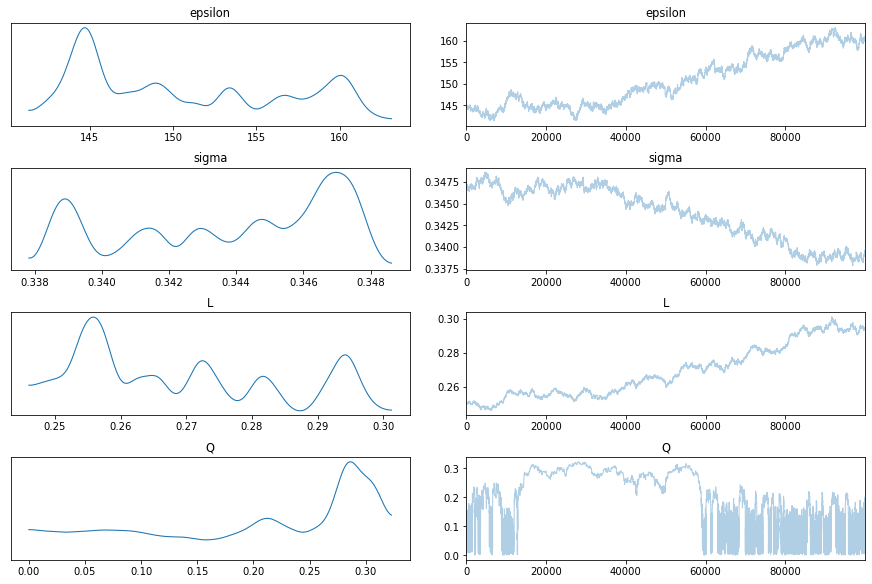

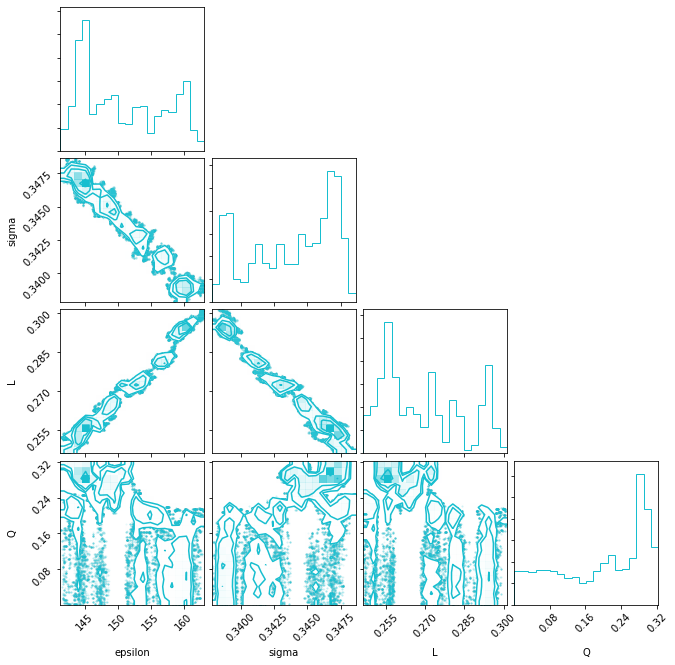

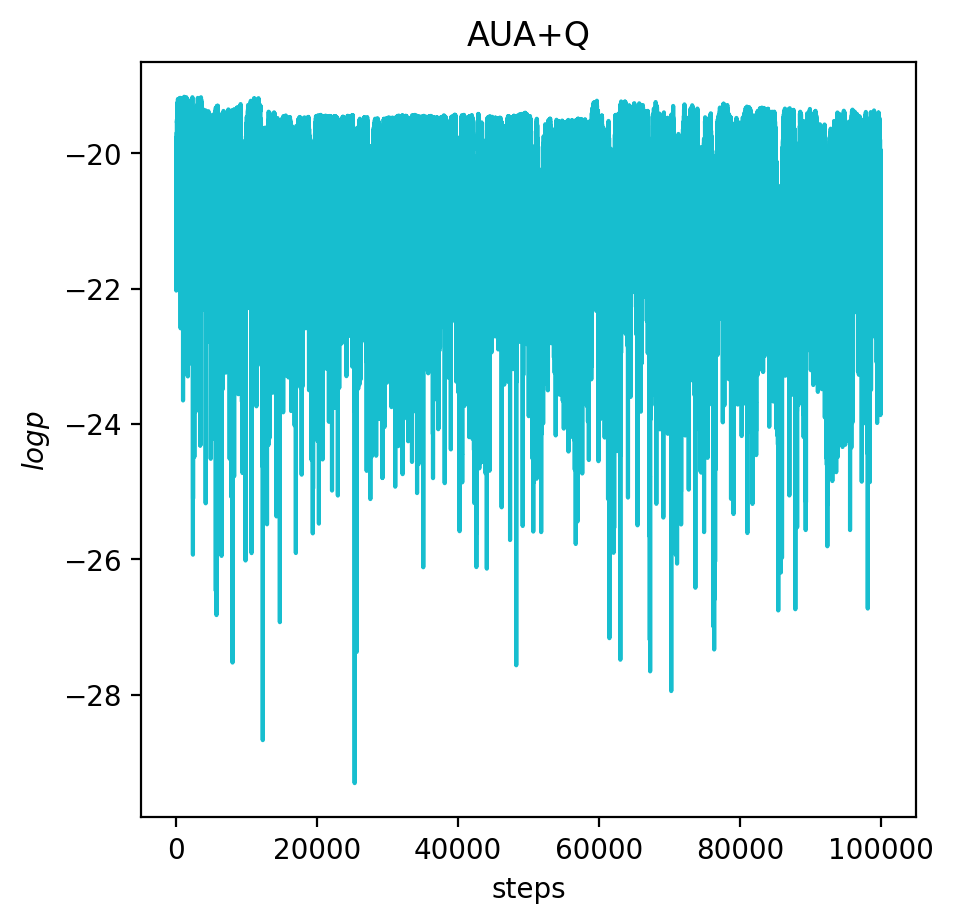

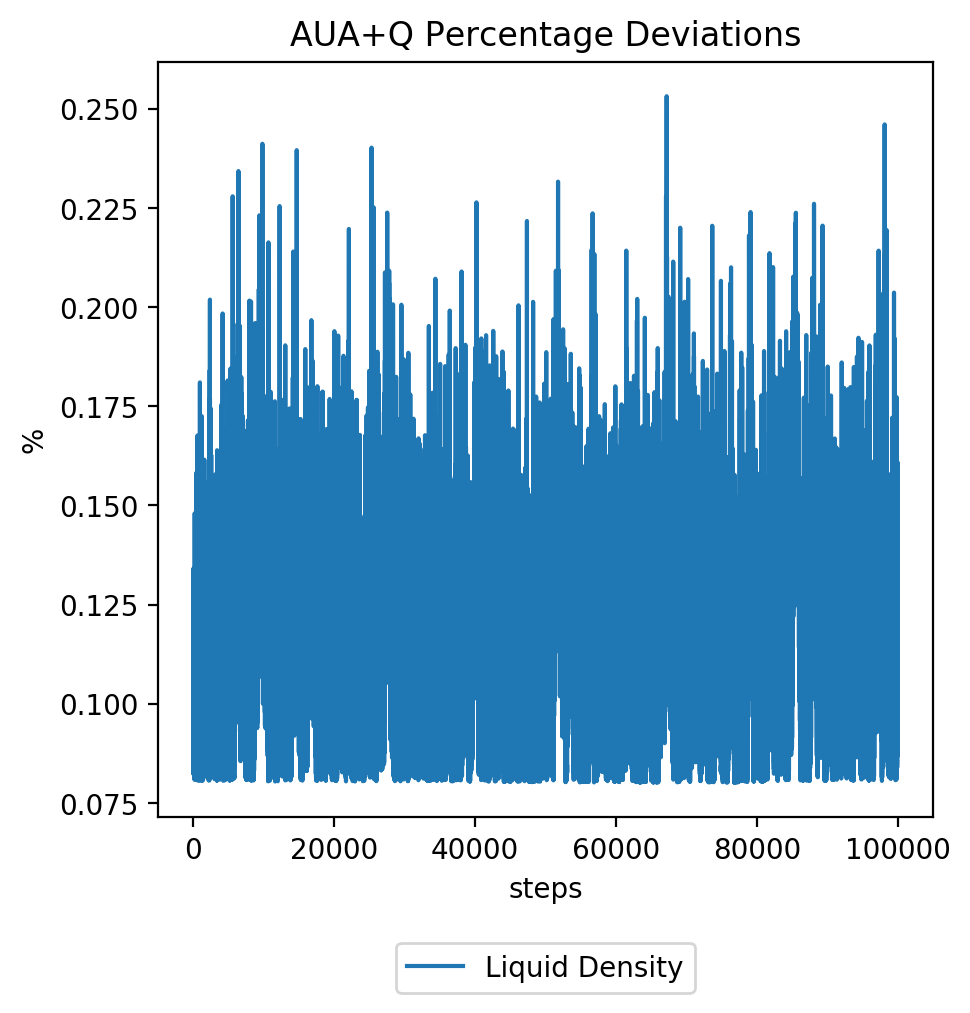


100%|█████████▉| 100000/100001 [00:52<00:00, 2880.82it/s]

In [8]:
from bayesiantesting.kernels import MCMCSimulation
from studies.utilities import get_2clj_model, parse_input_yaml, prepare_data


simulation_params = parse_input_yaml("basic_run.yaml")
#Import simulation parameters.  These include the priors, as well as information about which data to select
# and the parameters of the simulation.

data_set, property_types = prepare_data(simulation_params)
#Prepare the dataset and property types (we'll just look at density here)

initial_parameters = {
    "AUA+Q" : parameters,
}
#Starting with the same parameters as before, for the same model (AUA+Q)

model = get_2clj_model("AUA+Q", data_set, property_types, simulation_params)
#Build the model

simulation = MCMCSimulation(
    model_collection=model, initial_parameters=initial_parameters[model.name]
)
#Run the simulation

trace, log_p_trace, percent_deviation_trace = simulation.run(
    warm_up_steps=int(simulation_params["steps"] * 0.2),
    steps=simulation_params["steps"],
)

#Plot the output
model.plot(trace, log_p_trace, percent_deviation_trace, show=True)

There's lots of information here, but the triangle plot (4x4 plots in light blue, with 1-d histograms on the axis and 2-d histograms off axis) is the most interesting.  This essentially shows a bunch of 1-d and 2-d 'slices' of the 4 dimensional probability distribution.  The 2-d contours are analogous to a topographic map, but the 1-d slices are easy to interpret: higher y values = more probable parameter values.  There's more interesting information as well, like the shape of the distribution telling us about parameter sensitivity, but we can get a "quick and dirty" better set of parameters but taking the most probable (Maximum a posterior or MAP values).

By looking at the trace and binning the values we can get an idea of what the MAP values are:



In [6]:
MAP_values = []

for i in range(1,numpy.shape(trace)[1]):
    hist,values = numpy.histogram(trace[:,i],bins=100)
    max_index = numpy.argmax(hist)
    MAP_value = (values[max_index] + values[max_index+1])/2
    MAP_values.append(MAP_value)

MAP_values = numpy.asarray(MAP_values)

print(MAP_values)


[121.62184898   0.36044961   0.21475894   0.35249874]


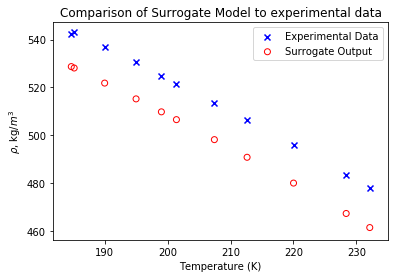

In [7]:
temperatures = numpy.asarray(ethane_densities['T (K)'])

new_parameters = MAP_values

ethane_surrogate_densities = testsurrogate.evaluate(density,new_parameters,temperatures)
#Evaluate the surrogate model (with parameters from before) for new temperatures


plt.scatter(temperatures,ethane_densities['rhol (kg/m3)'], marker='x', color='b',label='Experimental Data')
plt.scatter(temperatures,ethane_surrogate_densities, marker='o', facecolors='none',edgecolors='r',label='Surrogate Output')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\rho$, kg/$m^3$')
plt.title('Comparison of Surrogate Model to experimental data')
plt.legend()
plt.show()

Through better parameterization, our model now does a much better job at reproducing the experimental data!